In [4]:
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier
from weka.core.dataset import create_instances_from_matrices
from weka.core.dataset import Attribute, Instance, Instances
import weka.core.converters as converters

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

from warnings import simplefilter

In [5]:
# -- Start JVM

jvm.start()

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [6]:
# -- Init the Silencer

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [7]:
# --- Input Parameters

data_set_codes_general = ["cpu-stress", "mem-leak", "pack-loss", "pack-delay", "pack-corr"]
replicas_num = 3
approach = "p"

node_pairs_number = 10
number_of_kpis = 1720
classifier = "weka.classifiers.trees.LMT"
options = ["-I", "-1", "-M", "15", "-W", "0.0"]


# -- Pathes

# Path to the .csv file (Binary Anomaly Matrix)
bam_file_path = "resources/bams_shuffled/{data_set_code}-{node_pair_index}.csv"

# Path to the .csv file to save the point-level predictions
predictions_file_path = "resources/predictions-{approach}/{data_set_code}.csv"


# --- Input Parameters Processing

normal_class_label = str(len(data_set_codes_general) * node_pairs_number)
number_of_fault_types = len(data_set_codes_general)

In [8]:
# Functions

def load_csv(csv_file_path, source_data_set_code_list, mode, node_pairs_number, faulty_node_pair_index, number_of_kpis, normal_class_label, number_of_fault_types):
    
    ## Create attributes
    attributes = [Attribute.create_numeric(str(ii)) for ii in range(number_of_kpis)]
    attributes.append(Attribute.create_nominal("class", [str(fault_index * 10 + node_pair) for fault_index in range(number_of_fault_types) for node_pair in range(node_pairs_number)] + [normal_class_label]))

    ## Create dataset
    dataset = Instances.create_instances("data-set", attributes, 0)

    # Loop by data set groups
    for data_set_code_idx, data_set_code in enumerate(source_data_set_code_list):
        
        # Loop by the data sets inside each group
        for node_pair_index in range(0, node_pairs_number):
            
            # Skip all syntesized (not original) data sets for building a test dataset
            if mode == "test" and node_pair_index != faulty_node_pair_index:
                continue

            with open(csv_file_path.format(data_set_code=data_set_code, node_pair_index=node_pair_index), newline='') as csvfile:
                csv_reader = csv.reader(csvfile)
                next(csv_reader)
                for row in csv_reader:
                    
                    ## Add rows
                    vals = [int(item) for item in row[1 : number_of_kpis + 1]]
                    
                    if row[number_of_kpis + 1] == "n":
                        label = normal_class_label
                    else:
                        label = data_set_code_idx * 10 + node_pair_index
                        
                    vals.append(label)
                    
                    # Take the normal part only from the first data set in the data set group
                    if mode == "train" and node_pair_index > 0 and row[number_of_kpis + 1] == "n":
                        continue

                    inst = Instance.create_instance(vals)
                    dataset.add_instance(inst)

    dataset.class_is_last()

    return dataset


Test Data Set: ['cpu-stress-0']
Train Data Sets: ['mem-leak-0', 'pack-loss-0', 'pack-delay-0', 'pack-corr-0']




DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP2/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP2/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP

1: suspecious: 50 (67.23%)
2: suspecious: 50 (67.23%)
3: suspecious: 50 (67.23%)
4: suspecious: 50 (11.75%)
5: suspecious: 50 (64.56%)
6: suspecious: 50 (64.56%)
7: suspecious: 50 (64.56%)
8: suspecious: 50 (64.56%)
9: suspecious: 50 (64.56%)
10: suspecious: 50 (64.56%)
11: suspecious: 50 (64.56%)
12: suspecious: 50 (64.56%)
13: suspecious: 50 (64.56%)
14: suspecious: 50 (64.56%)
15: suspecious: 50 (64.56%)
16: suspecious: 50 (34.12%)
17: suspecious: 50 (34.12%)
18: suspecious: 50 (34.12%)
19: suspecious: 50 (34.12%)
20: suspecious: -1 (8.43%)
21: suspecious: -1 (8.43%)
22: suspecious: 50 (34.12%)
23: suspecious: -1 (8.43%)
24: suspecious: -1 (8.43%)
25: suspecious: -1 (8.43%)
26: suspecious: -1 (8.84%)
27: suspecious: 50 (34.12%)
28: suspecious: 50 (34.12%)
29: suspecious: -1 (8.58%)
30: suspecious: 50 (34.12%)
31: suspecious: 50 (34.12%)
32: suspecious: 50 (34.12%)
33: suspecious: 50 (34.12%)
34: suspecious: 50 (34.12%)
35: suspecious: 50 (34.12%)
36: suspecious: 50 (34.12%)
37: susp

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP2/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP2/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/usi/Prevent-2023-RP2/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 1

1: suspecious: 50 (84.16%)
2: suspecious: 50 (84.16%)
3: suspecious: 50 (79.10000000000001%)
4: suspecious: 50 (84.16%)
5: suspecious: 50 (84.16%)
6: suspecious: 50 (84.16%)
7: suspecious: 50 (79.10000000000001%)
8: suspecious: 50 (79.10000000000001%)
9: suspecious: 50 (79.10000000000001%)
10: suspecious: 50 (79.10000000000001%)
11: suspecious: 50 (84.16%)
12: suspecious: 50 (84.16%)
13: suspecious: 50 (84.16%)
14: suspecious: 50 (84.16%)
15: suspecious: 50 (84.16%)
16: suspecious: -1 (8.790000000000001%)
17: suspecious: 50 (84.16%)
18: suspecious: 50 (84.16%)
19: suspecious: 50 (84.16%)
20: suspecious: 50 (84.16%)
21: suspecious: 50 (84.16%)
22: suspecious: 50 (84.16%)
23: suspecious: 50 (27.42%)
24: suspecious: 50 (27.42%)


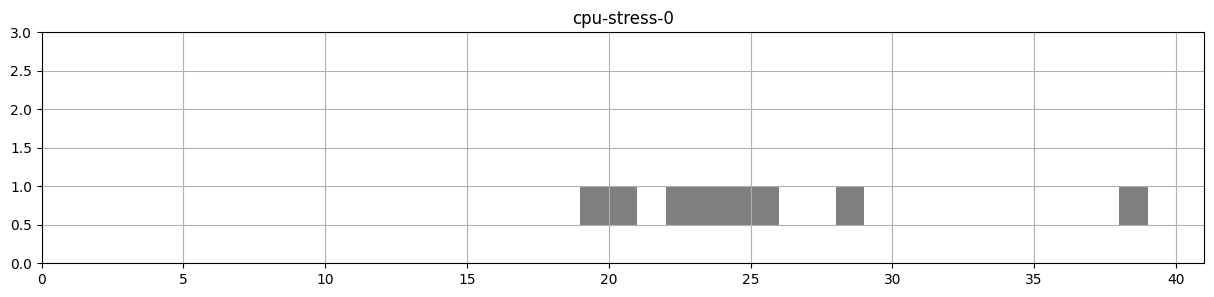

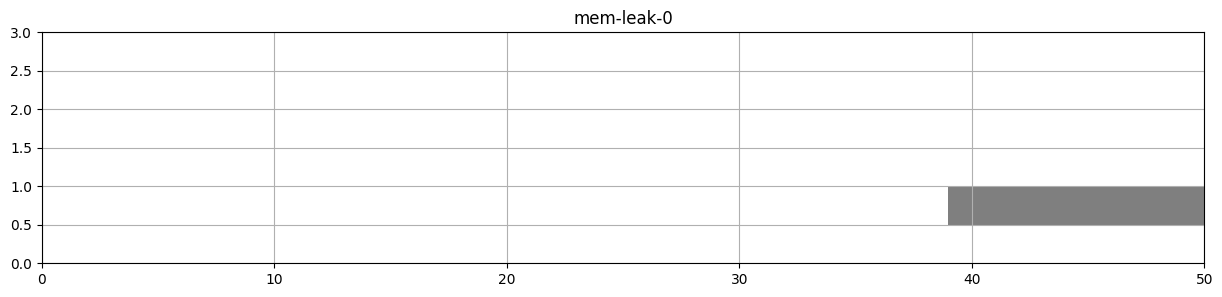

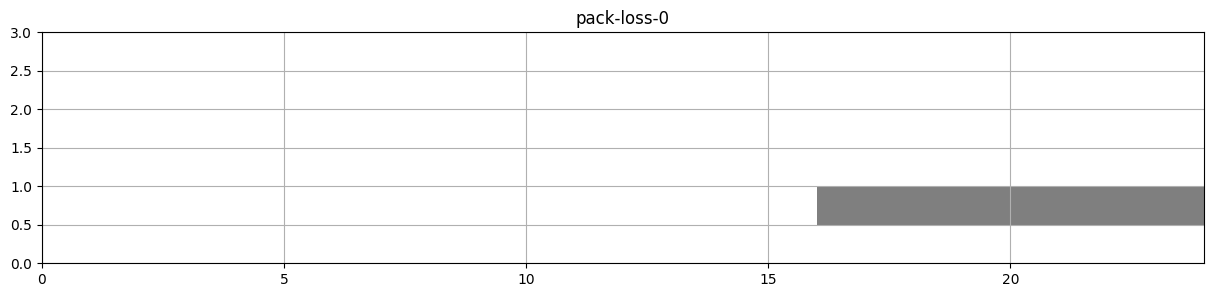

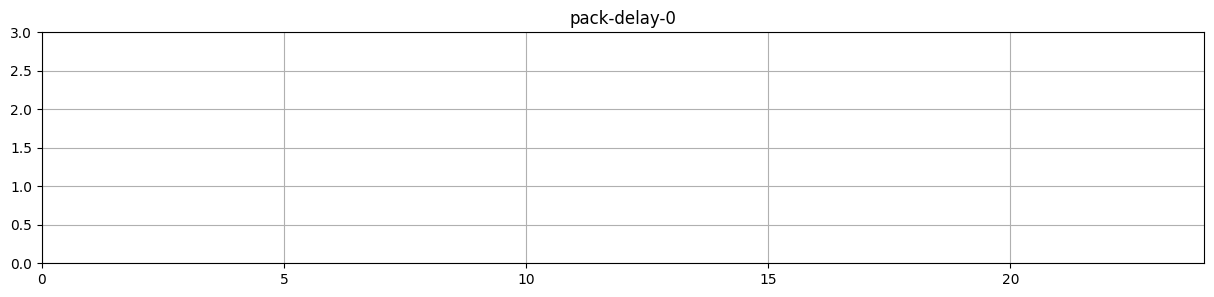

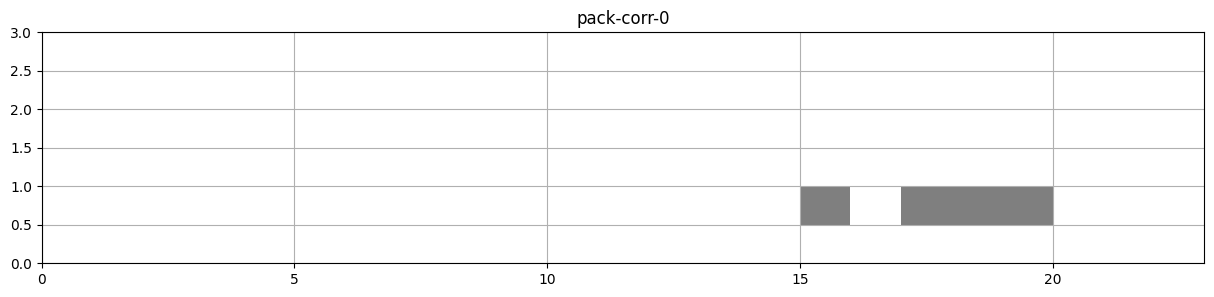

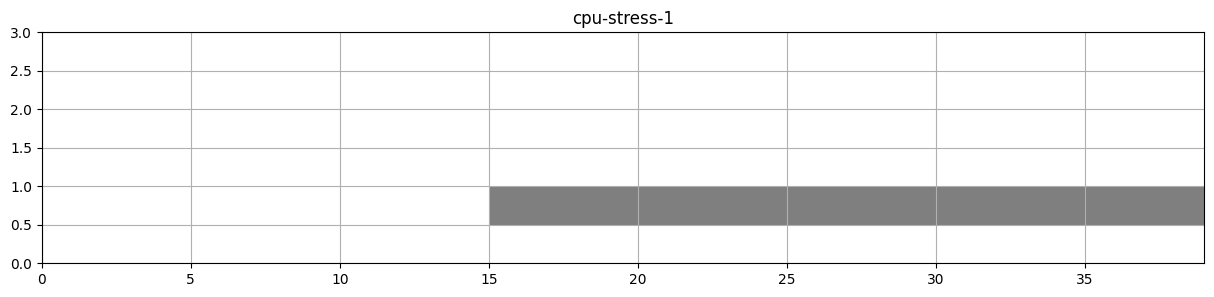

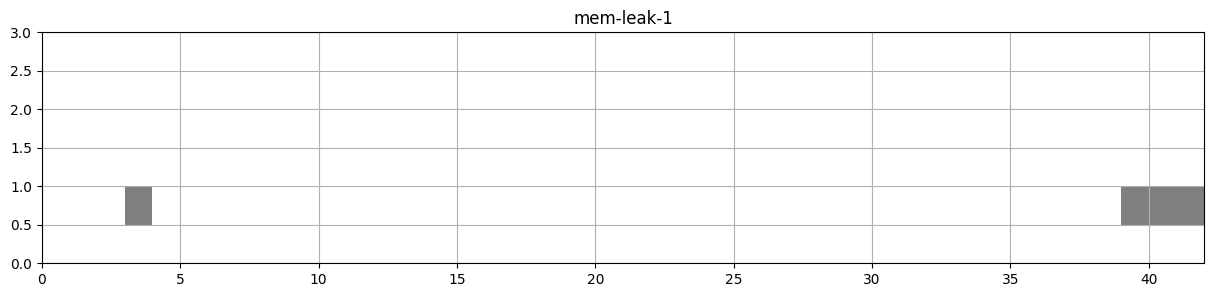

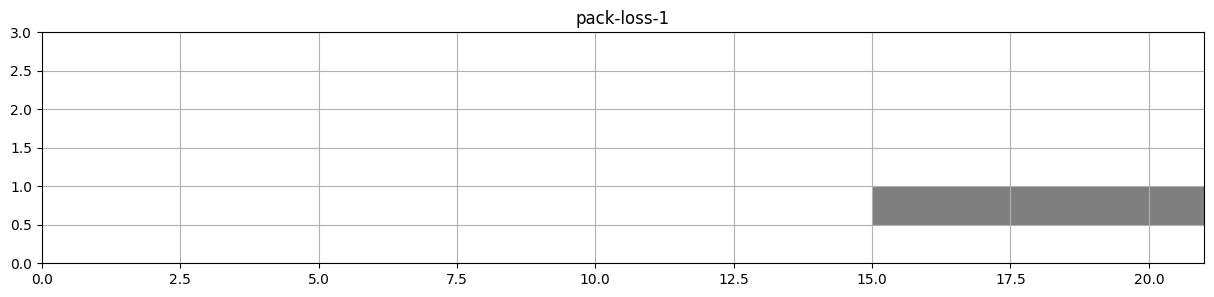

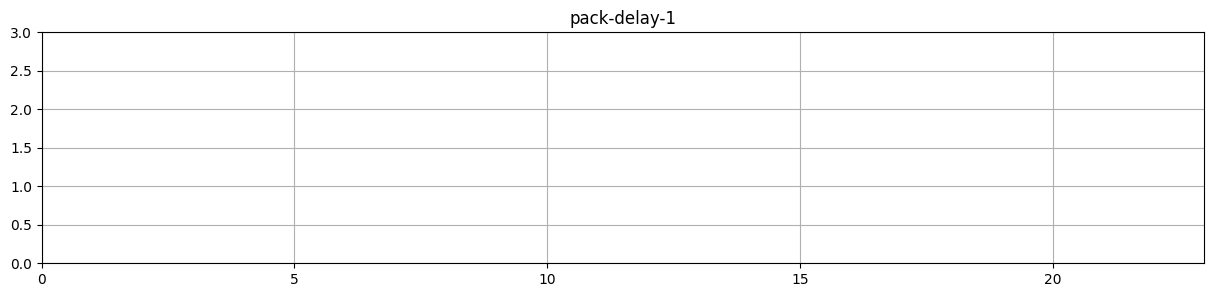

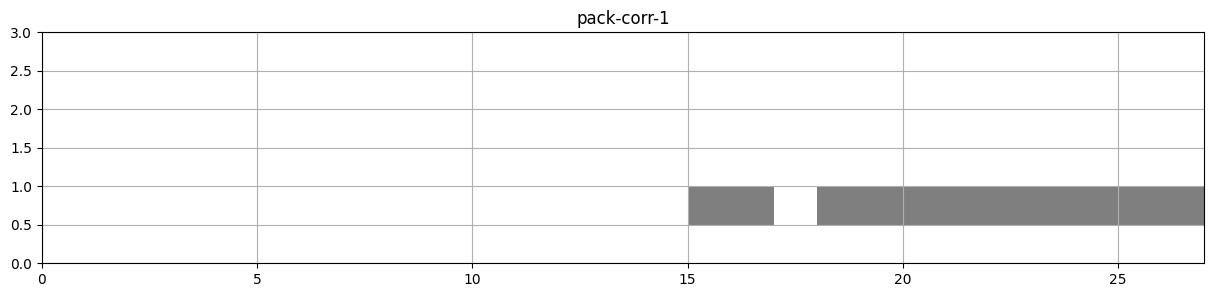

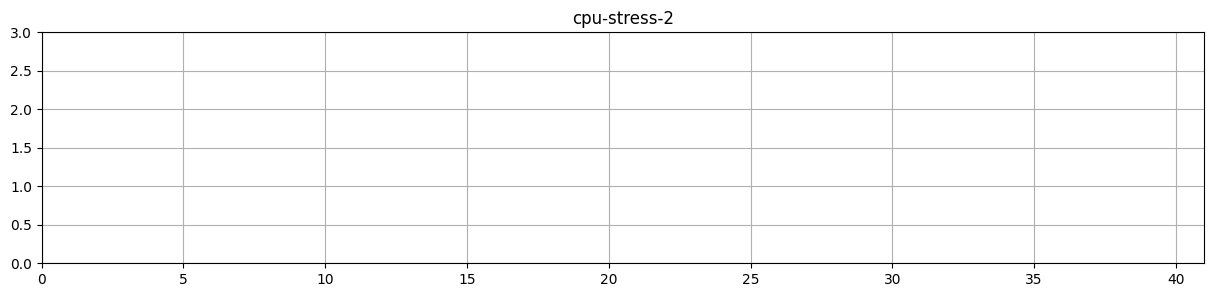

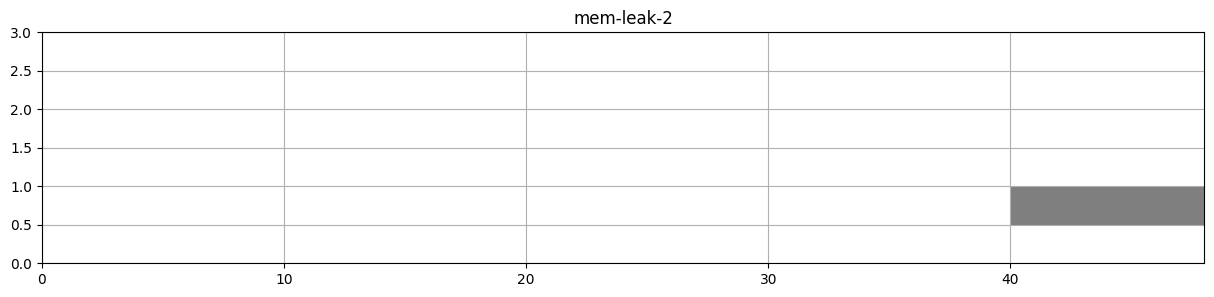

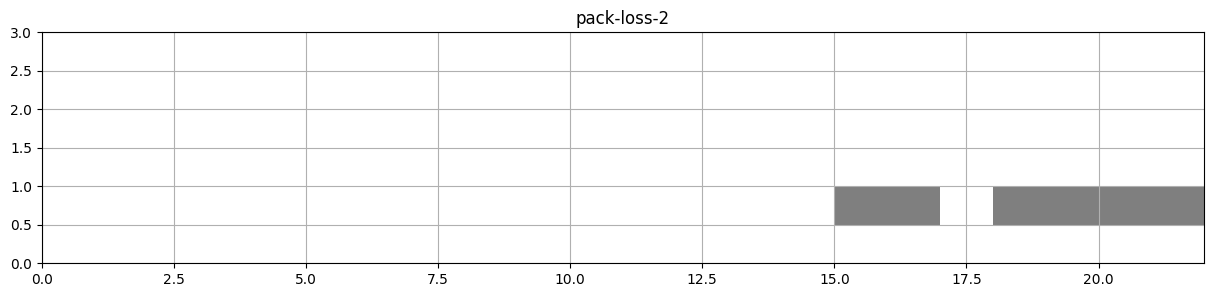

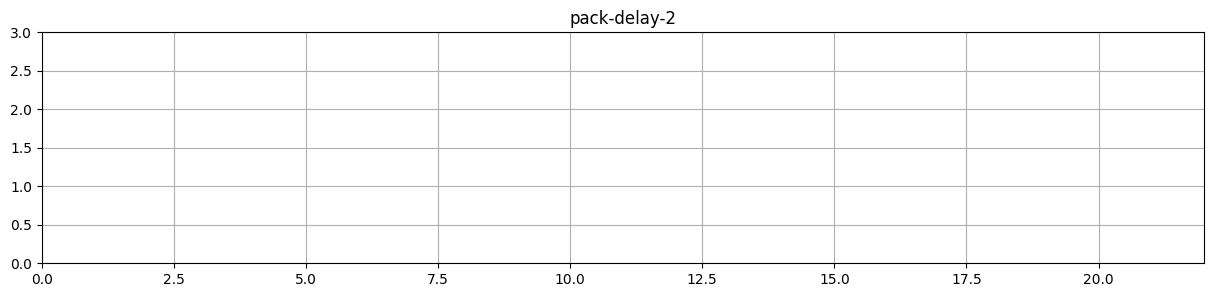

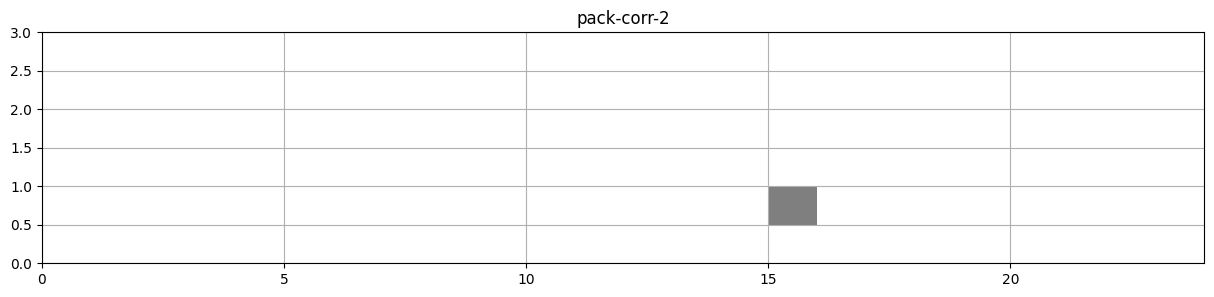

In [9]:
for replication in range(replicas_num):

    if replication == 0:
        faulty_pair_index = 9

    if replication == 1:
        faulty_pair_index = 1

    if replication == 2:
        faulty_pair_index = 2

    for general_code_idx, general_code in enumerate(data_set_codes_general):
        data_set_code = "{code}-{replica}".format(code=general_code, replica=replication)
    
        #### Load data
        
        # Get the codes of the training data sets 
        source_data_set_code_list_train = ["{code}-{replica}".format(code=code, replica=replication) for code in data_set_codes_general if code != general_code]

        # Get the code of the testng data set
        source_data_set_code_list_test = [data_set_code]
            
        # Load the data sets
        data_set_train = load_csv(bam_file_path, source_data_set_code_list_train, "train", node_pairs_number, faulty_pair_index, number_of_kpis, normal_class_label, number_of_fault_types)
        data_set_test = load_csv(bam_file_path, source_data_set_code_list_test, "test", node_pairs_number, faulty_pair_index, number_of_kpis, normal_class_label, number_of_fault_types)
        
        print("\nTest Data Set:", source_data_set_code_list_test)
        print("Train Data Sets:", source_data_set_code_list_train)
        print("\n")
    
        
        #### Build the classifier
        cls = Classifier(classname=classifier, options=options)

        
        #### Train the classifier
        cls.build_classifier(data_set_train)
    
        
        #### Classify
        classifications = []
        for minute, instance in enumerate(data_set_test):

            prediction = cls.classify_instance(instance)
            prediction_probablities_distribution = list(cls.distribution_for_instance(instance))
            prediction_probablities_distribution = [round(item, 4) * 100 for item in prediction_probablities_distribution]
            prediction_probablities_distribution_sorted = sorted(prediction_probablities_distribution, reverse=True)

            probability_1 = prediction_probablities_distribution_sorted[0]
            probability_2 = prediction_probablities_distribution_sorted[1]

            if probability_1 == probability_2:
                suspecious = -1
            else:
                suspecious = prediction_probablities_distribution.index(probability_1)

            print("{minute}: suspecious: {suspecious} ({probability}%)".format(minute=minute+1, suspecious=suspecious, probability=probability_1))
            # print("distribution=" + str(prediction_probablities_distribution))

            if suspecious == -1:
                classification = 1  # No classification -> Prediction. No localization
            else:
                if suspecious == int(normal_class_label):
                    classification = 0  # Classification as Normal -> No Prediction
                else:
                    suspecious_pair = suspecious % 10
                    if suspecious_pair == faulty_node_pair_index:
                        classification = 2  # Classification as Faulty. Faulty node pair detected -> Prediction. Localization
                    else:
                        classification = 1 # Classification as Faulty. Not-Faulty node pair detected -> Prediction. No localization

            classifications.append(classification)
        
        #### Save the classifications
        with open(predictions_file_path.format(data_set_code=data_set_code, approach=approach), 'w') as f:
            write = csv.writer(f)
            for classification in classifications:
                write.writerow([classification])

        #### Plot the classifications
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.grid()
        ax.set_title(data_set_code)
        ax.set_xlim([0, len(classifications)])
        ax.set_ylim([0, 3])

        for time_point, classification in enumerate(classifications):
            if classification == 0:
                color = "w"
                alpha = 1

            if classification == 1:
                color = "tab:grey"
                alpha = 1

            if classification == 2:
                color = "tab:orange"
                alpha = 1

            ax.broken_barh([(time_point, 1)], (0.5, 0.5), facecolors=(color), alpha=alpha)